# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# March 29, 2018

## Shape Analysis

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Literature / Useful References

- Jean Claude, Morphometry with R
- [Online](http://link.springer.com/book/10.1007%2F978-0-387-77789-4) through ETHZ
- [Buy it](http://www.amazon.com/Morphometrics-R-Use-Julien-Claude/dp/038777789X)
- John C. Russ, “The Image Processing Handbook”,(Boca Raton, CRC Press)
- Available [online](http://dx.doi.org/10.1201/9780203881095) within domain ethz.ch (or proxy.ethz.ch / public VPN) 
- Principal Component Analysis
 - Venables, W. N. and B. D. Ripley (2002). Modern Applied Statistics with S, Springer-Verlag
- Shape Tensors
 - http://www.cs.utah.edu/~gk/papers/vissym04/
 - Doube, M.,et al. (2010). BoneJ: Free and extensible bone image analysis in ImageJ. Bone, 47, 1076–9. doi:10.1016/j.bone.2010.08.023
 - Mader, K. , et al. (2013). A quantitative framework for the 3D characterization of the osteocyte lacunar system. Bone, 57(1), 142–154. doi:10.1016/j.bone.2013.06.026
 
 

# Previously on QBI ...

- Image Enhancment 
 - Highlighting the contrast of interest in images
 - Minimizing Noise
- Segmentation
 - Understanding value histograms
 - Dealing with multi-valued data
- Automatic Methods
 - Hysteresis Method, K-Means Analysis
- Regions of Interest
 - Contouring 
- Machine Learning

# Learning Objectives

### Motivation (Why and How?)
- How do we quantify where and how big our objects are?
- How can we say something about the shape?
- How can we compare objects of different sizes?
- How can we compare two images on the basis of the shape as calculated from the images?
- How can we put objects into an finite element simulation? or make pretty renderings?

# Outline

- Motivation (Why and How?)
- Object Characterization
- Volume
- Center and Extents
- Anisotropy

***

- Shape Tensor
- Principal Component Analysis
- Ellipsoid Representation
- Scale-free metrics
- Anisotropy, Oblateness
- Meshing
 - Marching Cubes
 - Isosurfaces
- Surface Area

# Motivation


We have dramatically simplified our data, but there is still too much.

- We perform an experiment bone to see how big the cells are inside the tissue
$$\downarrow$$ ![Bone Measurement](ext-figures/tomoimage.png) 

### 2560 x 2560 x 2160 x 32 bit
_56GB / sample_
- Filtering and Enhancement!  
$$\downarrow$$
- 56GB of less noisy data

***

- __Segmentation__

$$\downarrow$$

### 2560 x 2560 x 2160 x 1 bit
(1.75GB / sample)

- Still an aweful lot of data

# What did we want in the first place

### _Single number_:
* volume fraction,
* cell count,
* average cell stretch,
* cell volume variability

# Component Labeling

Once we have a clearly segmented image, it is often helpful to identify the sub-components of this image. The easist method for identifying these subcomponents is called component labeling which again uses the neighborhood $\mathcal{N}$ as a criterion for connectivity, resulting in pixels which are touching being part of the same object.


In general, the approach works well since usually when different regions are touching, they are related. It runs into issues when you have multiple regions which agglomerate together, for example a continuous pore network (1 object) or a cluster of touching cells.

Here we show some examples from Cityscape Data taken in Aachen (https://raw.githubusercontent.com/NVIDIA/pix2pixHD)

(256, 512, 4) (256, 512)


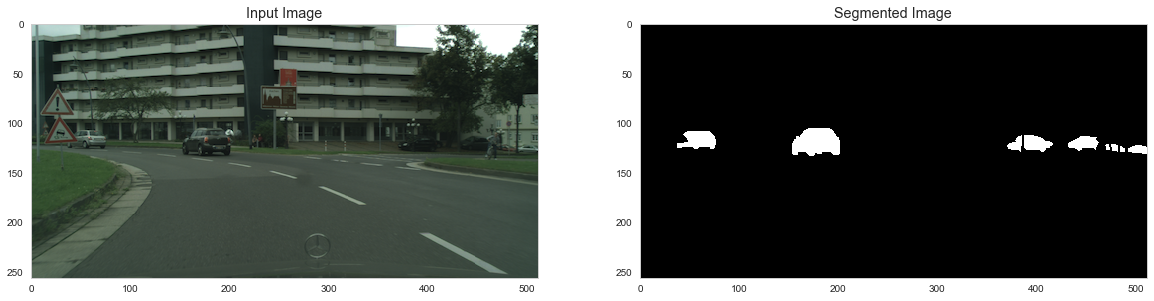

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

car_img = imread('ext-figures/aachen_img.png')
seg_img = imread('ext-figures/aachen_label.png')[::4, ::4]==26
print(car_img.shape, seg_img.shape)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 8))
ax1.imshow(car_img)
ax1.set_title('Input Image')

ax2.imshow(seg_img, cmap = 'bone')
ax2.set_title('Segmented Image');

The more general formulation of the problem is for networks (roads, computers, social). Are the points start and finish connected?

In [3]:
from skimage.morphology import label
help(label)

Help on function label in module skimage.measure._label:

label(input, neighbors=None, background=None, return_num=False, connectivity=None)
    Label connected regions of an integer array.
    
    Two pixels are connected when they are neighbors and have the same value.
    In 2D, they can be neighbors either in a 1- or 2-connected sense.
    The value refers to the maximum number of orthogonal hops to consider a
    pixel/voxel a neighbor::
    
      1-connectivity      2-connectivity     diagonal connection close-up
    
           [ ]           [ ]  [ ]  [ ]         [ ]
            |               \  |  /             |  <- hop 2
      [ ]--[x]--[ ]      [ ]--[x]--[ ]    [x]--[ ]
            |               /  |  \         hop 1
           [ ]           [ ]  [ ]  [ ]
    
    Parameters
    ----------
    input : ndarray of dtype int
        Image to label.
    neighbors : {4, 8}, int, optional
        Whether to use 4- or 8-"connectivity".
        In 3D, 4-"connectivity" means co

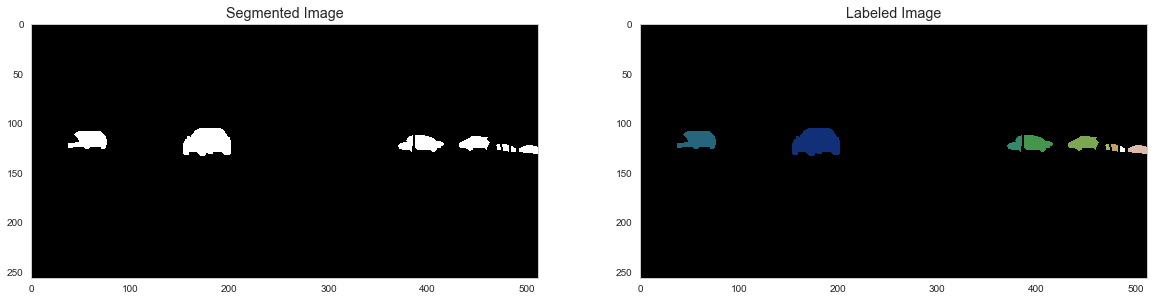

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 8))
ax1.imshow(seg_img, cmap = 'bone')
ax1.set_title('Segmented Image')
lab_img = label(seg_img)
ax2.imshow(lab_img, cmap = plt.cm.gist_earth)
ax2.set_title('Labeled Image');



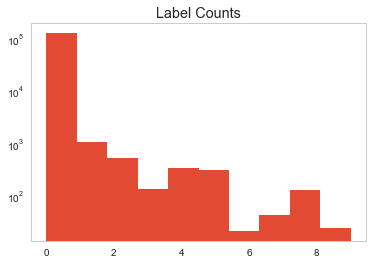

In [5]:
fig, (ax3) = plt.subplots(1,1)
ax3.hist(lab_img.ravel())
ax3.set_title('Label Counts')
ax3.set_yscale('log')

# Component Labeling: Algorithm

We start off with all of the pixels in either foreground (1) or background (0)

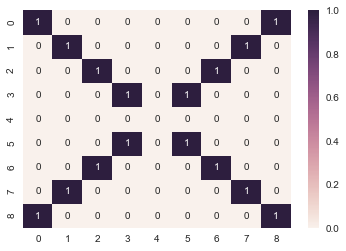

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage.morphology import label
seg_img = np.eye(9, dtype = int)
seg_img[4,4] = 0
seg_img += seg_img[::-1]
sns.heatmap(seg_img, annot=True, fmt="d")

Give each point in the image a unique label
- For each point $(x,y)\in\text{Foreground}$
 - Set value to $I_{x,y} = x+y*width+1$

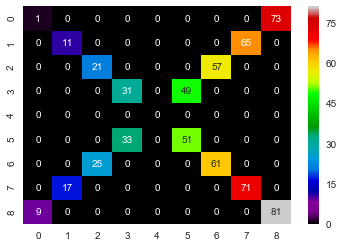

In [7]:
idx_img = np.zeros_like(seg_img)
for x in range(seg_img.shape[0]):
    for y in range(seg_img.shape[1]):
        if seg_img[x,y]>0:
            idx_img[x,y] = x+y*seg_img.shape[0]+1
sns.heatmap(idx_img, annot=True, fmt="d", cmap='nipy_spectral')            

In a [brushfire](http://www.sciencedirect.com/science/article/pii/S0921889007000966)-style algorithm
- For each point $(x,y)\in\text{Foreground}$
    - For each point $(x^{\prime},y^{\prime})\in\mathcal{N}(x,y)$
    - if $(x^{\prime},y^{\prime})\in\text{Foreground}$
        - Set the label to $\min(I_{x,y}, I_{x^{\prime},y^{\prime}})$
- Repeat until no more labels have been changed

(0, 8) 73 vs (1, 7) 65 -> 65
(1, 1) 11 vs (0, 0) 1 -> 1
(1, 7) 65 vs (2, 6) 57 -> 57
(2, 2) 21 vs (1, 1) 11 -> 11
(2, 6) 57 vs (3, 5) 49 -> 49
(3, 3) 31 vs (2, 2) 21 -> 21
(5, 3) 33 vs (6, 2) 25 -> 25
(6, 2) 25 vs (7, 1) 17 -> 17
(6, 6) 61 vs (5, 5) 51 -> 51
(7, 1) 17 vs (8, 0) 9 -> 9
(7, 7) 71 vs (6, 6) 61 -> 61
(8, 8) 81 vs (7, 7) 71 -> 71
Iteration 1 Groups 12 Changes 12
(0, 8) 65 vs (1, 7) 57 -> 57
(1, 7) 57 vs (2, 6) 49 -> 49
(2, 2) 11 vs (1, 1) 1 -> 1
(3, 3) 21 vs (2, 2) 11 -> 11
(5, 3) 25 vs (6, 2) 17 -> 17
(6, 2) 17 vs (7, 1) 9 -> 9
(7, 7) 61 vs (6, 6) 51 -> 51
(8, 8) 71 vs (7, 7) 61 -> 61
Iteration 2 Groups 8 Changes 8
(0, 8) 57 vs (1, 7) 49 -> 49
(3, 3) 11 vs (2, 2) 1 -> 1
(5, 3) 17 vs (6, 2) 9 -> 9
(8, 8) 61 vs (7, 7) 51 -> 51
Iteration 3 Groups 4 Changes 4
Done


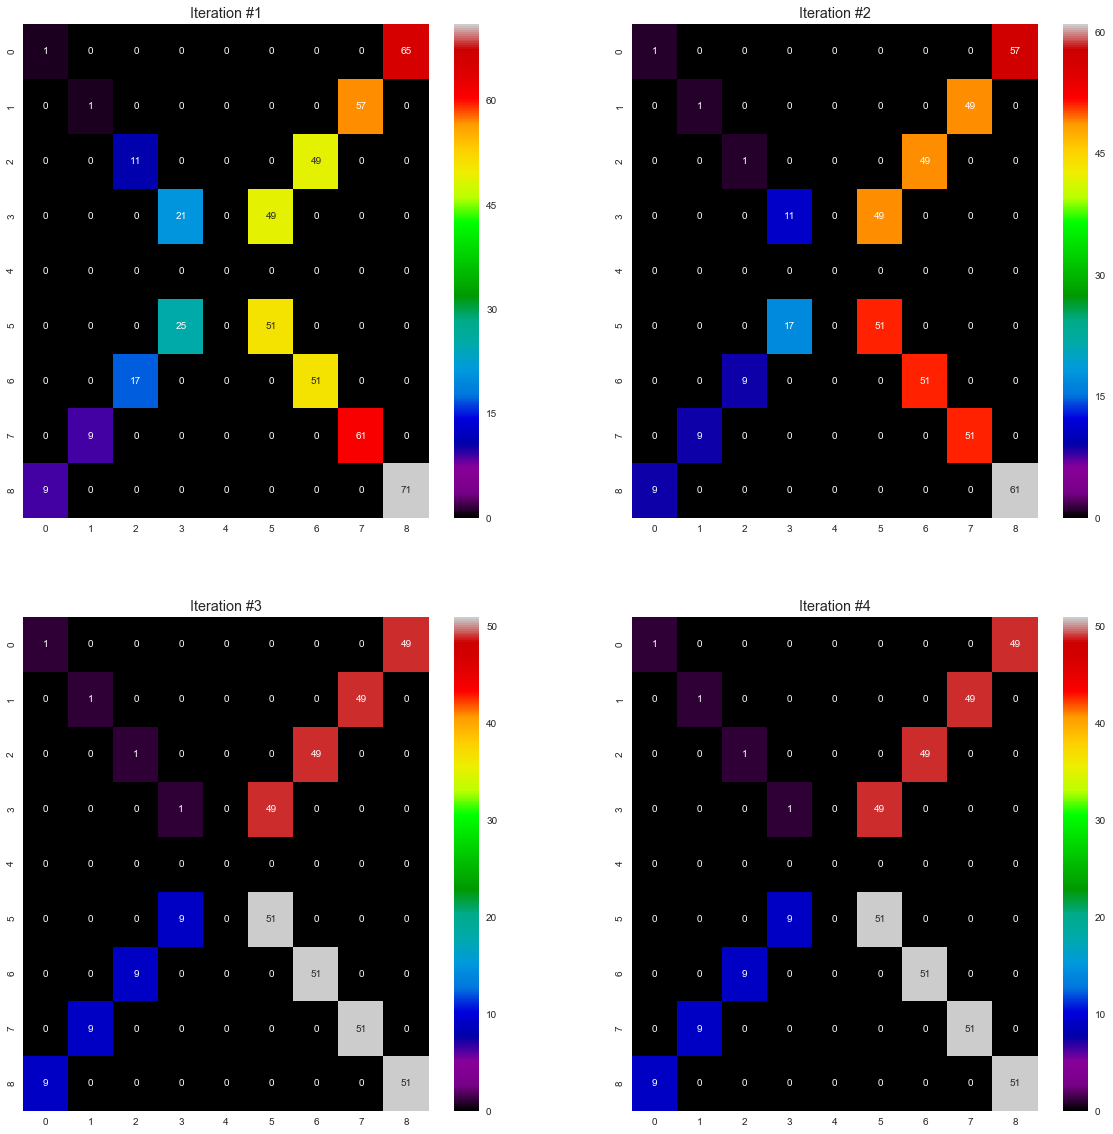

In [8]:
fig, m_axs = plt.subplots(2,2, figsize = (20, 20))
last_img = idx_img.copy()
for iteration, c_ax in enumerate(m_axs.flatten(),1):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x,y]>0:
                i_xy = last_img[x,y]
                for xp in [-1, 0, 1]:
                    if (x+xp<last_img.shape[0]) and (x+xp>=0):
                        for yp in [-1, 0, 1]:
                            if (y+yp<last_img.shape[1]) and (y+yp>=0):
                                i_xpyp = last_img[x+xp,y+yp]
                                if i_xpyp>0:
                                    
                                    new_val = min(i_xy, i_xpyp, cur_img[x,y])
                                    if cur_img[x,y]!=new_val:
                                        print((x,y), i_xy, 'vs', (x+xp,y+yp), i_xpyp, '->', new_val)
                                        cur_img[x,y] = new_val 
                                    
                                    
                        
    sns.heatmap(cur_img, 
                annot=True, 
                fmt="d", 
                cmap='nipy_spectral', 
                ax = c_ax)
    c_ax.set_title('Iteration #{}'.format(iteration))
    if (cur_img==last_img).all():
        print('Done')
        break
    else:
        print('Iteration', iteration, 
              'Groups', len(np.unique(cur_img[cur_img>0].ravel())),
              'Changes', np.sum(cur_img!=last_img))
        last_img = cur_img

# Bigger Images
How does the same algorithm apply to bigger images

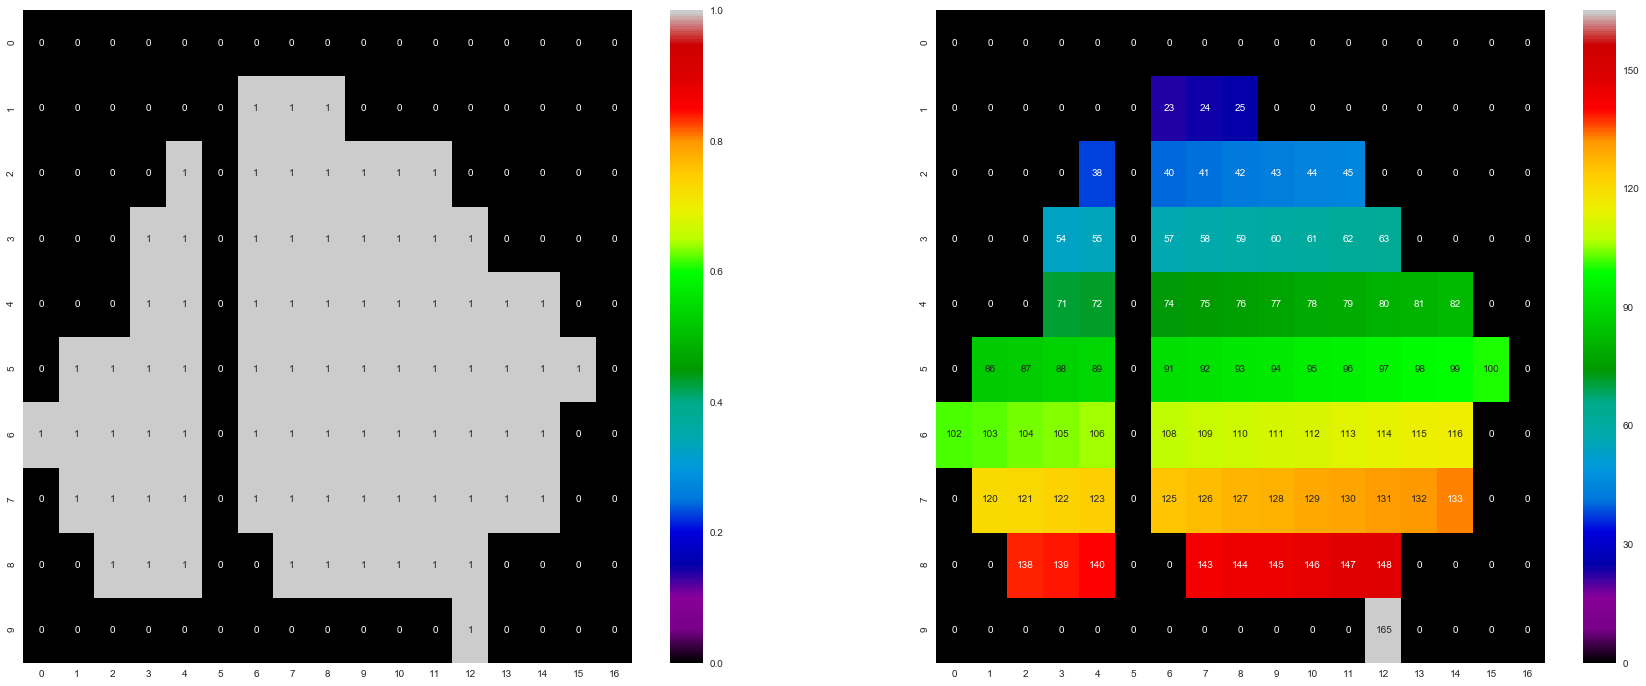

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage.morphology import label
from skimage.io import imread
seg_img = (imread('ext-figures/aachen_label.png')[::4, ::4]==26)[110:130:2, 370:420:3]
_, (ax1, ax2) = plt.subplots(1,2, figsize = (30, 12))
sns.heatmap(seg_img, annot=True, fmt="d", ax = ax1, cmap='nipy_spectral')
idx_img = seg_img * np.arange(len(seg_img.ravel())).reshape(seg_img.shape)
sns.heatmap(idx_img, annot=True, fmt="d", ax = ax2, cmap='nipy_spectral')  

In [10]:
last_img = idx_img.copy()
img_list = [last_img]
for iteration in range(99):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x,y]>0:
                i_xy = last_img[x,y]
                for xp in [-1, 0, 1]:
                    if (x+xp<last_img.shape[0]) and (x+xp>=0):
                        for yp in [-1, 0, 1]:
                            if (y+yp<last_img.shape[1]) and (y+yp>=0):
                                i_xpyp = last_img[x+xp,y+yp]
                                if i_xpyp>0:
                                    new_val = min(i_xy, i_xpyp, cur_img[x,y])
                                    if cur_img[x,y]!=new_val:
                                        cur_img[x,y] = new_val 
                                    
                                    
                        
    img_list += [cur_img]
    if (cur_img==last_img).all():
        print('Done')
        break
    else:
        print('Iteration', iteration, 
              'Groups', len(np.unique(cur_img[cur_img>0].ravel())),
              'Changes', np.sum(cur_img!=last_img))
        last_img = cur_img

Iteration 0 Groups 61 Changes 78
Iteration 1 Groups 45 Changes 73
Iteration 2 Groups 31 Changes 67
Iteration 3 Groups 21 Changes 58
Iteration 4 Groups 13 Changes 45
Iteration 5 Groups 7 Changes 30
Iteration 6 Groups 5 Changes 16
Iteration 7 Groups 3 Changes 6
Iteration 8 Groups 2 Changes 1
Done


In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
def update_frame(i):
    plt.cla()
    sns.heatmap(img_list[i], 
                annot=True, 
                fmt="d", 
                cmap='nipy_spectral', 
                ax = c_ax,
               cbar = False)
    c_ax.set_title('Iteration #{}, Groups {}'.format(i+1, 
                                                     len(np.unique(img_list[i][img_list[i]>0].ravel()))))
# write animation frames
anim_code = FuncAnimation(fig, 
                     update_frame, 
                     frames=len(img_list)-1, 
                     interval=500).to_html5_video()
plt.close('all')
HTML(anim_code)